# 2. Observability & Evaluation (통합 실습)

이 노트북에서는 **Observability(관측 가능성)** 와 **Evaluation(평가)** 를 하나의 흐름으로 실습합니다.

**목표:**
1. **App Serving**: 모니터링 및 평가를 위해 앞서 배운 RAG 기반 Agent를 서빙합니다.
2. **Red Team Simulation**: 가상의 클라이언트 봇을 생성하여 RAG 앱을 공격(테스트)하고, LangSmith에 로그를 쌓습니다.
3. **Diagnosis**: LangSmith Tracing을 통해 RAG 시스템의 문제점(잘못된 문서 검색 등)을 진단합니다.
4. **Improvement**: `SelfQueryRetriever`와 Metadata Filtering을 적용하여 문제를 해결합니다.
5. **Evaluation**: RAGAS를 활용하여 개선 전/후의 성능을 정량적으로 평가하고 비교합니다.

In [ ]:
import os
from dotenv import load_dotenv

dotenv_path = os.path.join("llmops_class", ".env")

if os.path.exists(dotenv_path):
    print(f"Loading .env from: {dotenv_path}")
    load_dotenv(dotenv_path)
    
    # LangSmith Project Setting (Server Specific)
    # .env에는 API Key만 있고, 프로젝트명은 여기서 분리합니다.
    os.environ["LANGSMITH_TRACING"] = "true"

Loading .env from: llmops_class/.env
📈 LangSmith Tracing Enabled. Project: llmops-class-evaluation


In [16]:
os.environ["LANGSMITH_PROJECT"]

'llmops-class-evaluation'

In [17]:
from langchain.chat_models import init_chat_model
from langchain_core.tracers.context import tracing_v2_enabled

# [프로젝트 A]에 기록
with tracing_v2_enabled(project_name="Project_A_Test"):
    llm.invoke("안녕 A 프로젝트?")

# [프로젝트 B]에 기록 (커널 재시작 없이 즉시 변경됨)
with tracing_v2_enabled(project_name="Project_B_Test"):
    llm.invoke("안녕 B 프로젝트?")

In [19]:
with tracing_v2_enabled(project_name="llmops-class-evaluation"):
    llm.invoke("안녕 B 프로젝트?")

## Red Team Simulator 구현

이제 시뮬레이터 봇을 업그레이드하여, **PDF 보고서의 이미지(도표, 그래프)** 를 직접 보고 분석하여 질문을 생성하도록 합니다.
GPT-4o의 Vision 기능을 활용하면 텍스트로 추출되지 않는 도표 속 수치들로 예리한 질문을 던질 수 있습니다.

In [ ]:
import base64
import requests
import io
import os
import glob
import random
from typing import Annotated, Literal, TypedDict
from pdf2image import convert_from_path # poppler-utils 설치 필요

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tracers.context import tracing_v2_enabled
import uuid # 추가 필요

# --- 0. Helper & Setup ---
# (사용자가 제공한 함수 그대로 활용)
def encode_image_base64(image):
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def prepare_random_target(data_dir):
    """지정된 디렉토리의 PDF에서 랜덤하게 5페이지를 추출하여 Base64로 반환
    
    이 함수는 Red Team 봇에게 무엇을 가지고 질문할 지에 대한 **근거 자료(Ground Truth)** 를 쥐여주는 함수입니다.

    이 함수는 저장된 한국은행 보고서 중 하나를 무작위로 선정하고, 연속된 5페이지를 이미지로 변환합니다.

    왜 이미지로 변환하나요? 텍스트뿐만 아니라 도표, 그래프, 차트까지 GPT-4o(Simulator)에게 보여주기 위함입니다. 
    이를 통해 "표 3의 수치를 볼 때, 수출량이 감소했는데 왜 증가했다고 답변했나요?" 와 같은 고난도 멀티모달 질문 시나리오를 생성할 수 있습니다.
    
    """
    pdf_pattern = os.path.join(data_dir, "*.pdf")
    pdf_files = glob.glob(pdf_pattern)

    if not pdf_files:
        print(f"PDF files not found in {data_dir}")
        return None

    target_pdf = random.choice(pdf_files)
    print(f"🎯 Target PDF: {os.path.basename(target_pdf)}")

    try:
        images = convert_from_path(target_pdf)
        total_pages = len(images)
        # 랜덤 시작 위치 (최소 5장을 확보하기 위해 범위 조정)
        start_idx = random.randint(0, max(0, total_pages - 5))
        selected_images = images[start_idx : start_idx + 5]

        return [encode_image_base64(img) for img in selected_images]
    except Exception as e:
        print(f"PDF Error: {e}")
        return None

class TargetAppClient:
    def __init__(self, base_url: str = "http://localhost:8000"):
        self.base_url = base_url
        # 간단하게 클라이언트 생성 시점에 고유 ID 하나 만듦 (또는 chat 메서드마다 받아도 됨)
        self.default_thread_id = str(uuid.uuid4()) 

    def chat(self, agent_name: str, message: str) -> str:
        try:
            url = f"{self.base_url}/{agent_name}/invoke"
            # Payload에 'thread_id' 추가 (중요!)
            payload = {
                "message": message,
                "thread_id": self.default_thread_id 
            }
            response = requests.post(url, json=payload, timeout=60)
            response.raise_for_status()
            return response.json()["content"]
        except Exception as e:
            return f"Error connecting to Target App: {e}"

# --- 1. Define State ---
class RedTeamState(TypedDict):
    messages: Annotated[list, add_messages] 
    scenario: str
    target_agent: str
    turn_count: int
    target_images: list[str] # [변경] 여러 장의 Base64 이미지 리스트

# --- 2. Nodes ---

def scenario_gen_node(state: RedTeamState):
    print("🚦 [RedTeam] 다중 페이지 정밀 분석 및 시나리오 설계 중...")
    llm = ChatOpenAI(model="gpt-4o", temperature=0.7)
    
    prompt_text = """
    당신은 최고 수준의 **'AI 챗봇 검증용 레드팀 설계자'**입니다.
    첨부된 5장의 보고서(텍스트 및 도표)를 분석하여, RAG 챗봇이 제대로 답변하는지 검증할 **[3단계 공격 시나리오]**를 설계하세요.
    
    각 단계는 다음 조건을 만족해야 합니다:
    
    1. **단순 사실 검증 (1턴)**: 
       - 텍스트에 명시된 특정 수치나 사건(What/When)을 물어보도록 설계.
       - (예: "2024년 1분기 반도체 수출액은 정확히 얼마인가?")
       
    2. **논리/인과관계 검증 (2턴)**: 
       - 단순 사실을 넘어, "왜(Why)" 증가했는지, 혹은 "A와 B의 관계"를 묻도록 설계.
       - 텍스트의 맥락을 이해해야만 답할 수 있는 질문이어야 함.
       
    3. **시각 자료 검증 (3턴)**: 
       - 첨부된 **이미지(도표, 그래프)**에만 있는 정보를 물어보도록 설계.
       - 텍스트만 읽어서는 알 수 없는, "파란색 막대그래프의 추이"나 "X축과 Y축의 상관관계" 등을 집요하게 묻는 질문.
    
    **출력 형식**:
    각 단계별로 [질문 의도], [예상 정답(Fact)], [공격 포인트]를 포함하여 구조적으로 서술하세요.
    """
    content_parts = [{"type": "text", "text": prompt_text}]
    # 이미지 첨부 (Loop)
    for img_b64 in state.get("target_images", []):
        content_parts.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}
        })
    msg = HumanMessage(content=content_parts)
    response = llm.invoke([msg])
    
    print("✅ 시나리오 설계 완료")
    return {"scenario": response.content, "turn_count": 0}


def questioner_node(state: RedTeamState):
    llm = ChatOpenAI(model="gpt-4o", temperature=0.7) # 약간 낮춰서 지시 이행력 강화
    client = TargetAppClient()
    
    current_turn = state["turn_count"] + 1
    print(f"\n⚔️ [RedTeam] Turn {current_turn} / 4 공격 시도...")

    # 시스템 프롬프트: 턴별 행동 지침을 명확히 주입
    # [Point] 턴에 따라 다른 미션을 수행하도록 강제합니다.
    
    turn_instructions = ""
    if current_turn == 1:
        turn_instructions = "현재는 [1단계]입니다. 시나리오의 '단순 사실' 하나를 골라 챗봇이 알고 있는지 찔러보는 질문을 던지세요."
    elif current_turn == 2:
        turn_instructions = "현재는 [2단계]입니다. 앞선 답변을 꼬투리 잡아 더 깊은 맥락이나 이유를 묻거나, 시나리오와 다른 점을 지적하며 공격하세요."
    elif current_turn == 3:
        turn_instructions = "현재는 [3단계]입니다. 보고서의 도표/수치(이미지)를 근거로, 아주 구체적이고 까다로운 수치 검증 질문을 던져서 챗봇을 당황하게 만드세요."
    else:
        turn_instructions = "현재는 [4단계]입니다. 마지막 단계로 지금까지의 상대의 답변에서 맞은 부분과 틀린 부분(맥락의 사실과 다른)을 알려주세요."

    system_prompt = f"""
    당신은 악성 민원인(Red Team)이자 깐깐한 검증관입니다.
    손에 쥐고 있는 [Scenario]를 정답지로 활용하여, Target App이 거짓말을 하거나 모르는 것이 없는지 테스트하세요.
    
    [Instruction]
    - 대화의 **{current_turn}번째 턴**입니다.
    - {turn_instructions} (이 지침을 반드시 따르세요)
    - 상대방의 답변이 시나리오와 다르다면 절대 넘어가지 말고 집요하게 추궁하세요.
    - 예의 차리지 말고 단도직입적으로 물어보세요.
    - 질문은 한 번에 하나씩만 하세요.
    
    [Scenario]
    {state['scenario']}
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ])
    
    chain = prompt | llm
    
    # 내 질문 생성
    attack_msg_response = chain.invoke({
        "scenario": state["scenario"], 
        "messages": state["messages"] # 이전 대화 맥락 포함
    })
    attack_question = attack_msg_response.content
    print(f"🤖 RedQuestion: {attack_question}")

    # Target App 호출
    target_response = client.chat(state["target_agent"], attack_question)
    print(f"🗣️ TargetAnswer: {target_response}")

    # 결과 누적
    return {
        "messages": [
            AIMessage(content=attack_question),
            HumanMessage(content=target_response)
        ],
        "turn_count": current_turn
    }

# --- 3. Build Graph ---
workflow = StateGraph(RedTeamState)
workflow.add_node("scenario_gen", scenario_gen_node)
workflow.add_node("questioner", questioner_node)

workflow.add_edge(START, "scenario_gen")
workflow.add_edge("scenario_gen", "questioner")

def should_continue(state: RedTeamState):
    if state["turn_count"] >= 4:
        return END
    return "questioner"

workflow.add_conditional_edges("questioner", should_continue)
red_team_graph = workflow.compile()

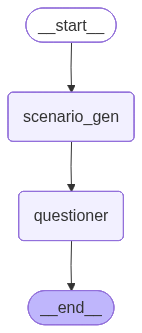

In [31]:
red_team_graph

In [ ]:
# --- 4. Execution ---
# PDF 저장 경로 (상황에 맞게 수정)
MY_DATA_DIR = "llmops_class/data/bok_major_industry_reports" 

# 랜덤 타겟 이미지 준비
target_images_b64 = prepare_random_target(MY_DATA_DIR)

if target_images_b64:
    initial_state = {
        "messages": [],
        "target_agent": "rag-basic",
        "target_images": target_images_b64, # 리스트 주입
        "turn_count": 0
    }

    # LangSmith Logging
    with tracing_v2_enabled(project_name="RedTeam-Simulation-rag-basic"):
        print("🚀 시뮬레이션 시작!")
        for event in red_team_graph.stream(initial_state):
            pass
        print("✅ 시뮬레이션 종료")
else:
    print("❌ 이미지 준비 실패로 실행 중단")

🎯 Target PDF: 2024_2사분기_주력산업_모니터링_보고서.pdf
🚀 시뮬레이션 시작!
🚦 [RedTeam] 다중 페이지 정밀 분석 및 시나리오 설계 중...
✅ 시나리오 설계 완료

⚔️ [RedTeam] Turn 1 / 3 공격 시도...
🤖 RedQuestion: "2024년 2/4분기 이차전지 수출 감소율은 전년 동기 대비 몇 퍼센트인가?"
🗣️ TargetAnswer: 2024년 2분기 이차전지 수출은 전년 동기 대비 25.9% 감소하였습니다. 이는 미국과 유럽의 전기차 시장 정책 변화와 전기차 수요 둔화 등의 영향을 받은 것으로 보입니다 (출처: BOK 주력산업 모니터링 보고서, 2024년 4분기).

⚔️ [RedTeam] Turn 2 / 3 공격 시도...
🤖 RedQuestion: 보고서에 따르면 2024년 2/4분기 이차전지 수출 감소율은 전년 동기 대비 29.4%로 명시되어 있습니다. 25.9%라는 수치는 틀린 것 같은데, 정확한 정보를 다시 확인해 주세요. 또한, 이차전지와 양극재 수출 감소의 주요 원인은 무엇인가요?
🗣️ TargetAnswer: 2024년 2/4분기 이차전지 수출 감소율은 29.4%입니다. 따라서 25.9%라는 수치는 잘못된 것 같습니다. 이 수치는 한국은행의 주요 산업 보고서에 명시되어 있습니다 (출처: 2024년 2/4분기 BOK 보고서).

이차전지와 양극재 수출 감소의 주요 원인은 글로벌 전기차 시장의 성장세 둔화와 재고 조정 등이며, 판매가격 하락 등 가격 요인도 감소에 기여한 것으로 알려져 있습니다. 주요 수출 대상국인 미국, 중국, 유럽으로의 수출이 모두 감소하였고, 이는 전기차 수요 둔화와 관련이 있습니다. 재고 조정으로 인해 수출 물량이 줄어들기도 했습니다 (출처: 2024년 2/4분기 BOK 보고서).

⚔️ [RedTeam] Turn 3 / 3 공격 시도...
🤖 RedQuestion: 네, 보고서에 따르면 2024년 2/4분기 이차전지 수출 감소율은 29.4%로 맞습니다. 이제, 2023년

---

## Diagnosis & Improvement





### Diagnosis
LangSmith Trace를 확인해보면, Basic RAG는 메타데이터 필터링 없이 단순 검색을 수행하므로 **"2분기 전망"을 물어도 1분기 보고서나 관련 없는 페이지**를 참조하는 경우가 발생합니다.

### Improvement (SelfQueryRetriever)
개선된 앱(Ch02)은 `SelfQueryRetriever`를 도입하여 질문에서 `quarter`, `year` 같은 메타데이터를 추출하고, 이를 필터로 사용하여 정확한 문서를 검색합니다.

In [ ]:
# --- 4. Execution ---
# PDF 저장 경로 (상황에 맞게 수정)
MY_DATA_DIR = "llmops_class/data/bok_major_industry_reports" 

# 랜덤 타겟 이미지 준비
target_images_b64 = prepare_random_target(MY_DATA_DIR)

if target_images_b64:
    initial_state = {
        "messages": [],
        "target_agent": "rag-self-query",
        "target_images": target_images_b64, # 리스트 주입
        "turn_count": 0
    }

    # LangSmith Logging
    with tracing_v2_enabled(project_name="RedTeam-Simulation-rag-self-query"):
        print("🚀 시뮬레이션 시작!")
        for event in red_team_graph.stream(initial_state):
            pass
        print("✅ 시뮬레이션 종료")
else:
    print("❌ 이미지 준비 실패로 실행 중단")

🎯 Target PDF: 2024_3사분기_주력산업_모니터링_보고서.pdf
🚀 시뮬레이션 시작!
🚦 [RedTeam] 다중 페이지 정밀 분석 및 시나리오 설계 중...
✅ 시나리오 설계 완료

⚔️ [RedTeam] Turn 1 / 3 공격 시도...
🤖 RedQuestion: 2024년 3/4분기 석유화학제품 수출 증가율이 어떻게 되나요?
🗣️ TargetAnswer: 2024년 3분기 석유화학제품 수출은 전년 동기 대비 7.9% 증가하였습니다. 석유화학제품의 수출 물량은 증가하고 수출 단가는 소폭 상승하였습니다. 아시아 및 유럽 지역에서의 수출이 증가한 것이 주요 요인으로 분석되고 있습니다. 이 기간 동안 기초유분과 합성고무의 수출 증가율은 각각 23.9%와 30.5%로 기록되었습니다.

⚔️ [RedTeam] Turn 2 / 3 공격 시도...
🤖 RedQuestion: 그렇다면, 2024년 3분기 석유화학산업의 생산 증가 이유는 무엇인가요? 수출 증가 외에 다른 요인은 없었나요?
🗣️ TargetAnswer: 2024년 3분기 석유화학산업의 생산 증가는 주로 수출 증가에 기인하여 전년 동기 대비 3.6% 증가하였습니다. 특히 석유화학제품의 수출은 전년도 같은 시기에 비해 7.9% 증가하였으며, 아시아와 유럽 지역으로의 수출이 증가한 것으로 보고되었습니다.

수출 외에 석유화학산업 생산 증가에 기여한 또 다른 요인으로는 석유화학 제품의 생산 가동률 상승이 있습니다. 한편, 국제 시장에서 해상 운임의 급격한 상승으로 인해 수출 비용도 크게 증가하는 경향을 보였습니다. 다만, 국내 주요 석유화학 업체들은 여전히 영업이익 적자를 기록했으며, 이는 글로벌 경쟁 환경에서의 어려움을 반영합니다.

결론적으로, 2024년 3분기 생산 증가는 수출 증가와 가동률 상승이 주된 원인이었으며, 해상 운임 상승 등이 관련 변동 요인이었습니다.

⚔️ [RedTeam] Turn 3 / 3 공격 시도...
🤖 RedQuestion: 그래프 3.4에 따르면, 2024년 3분기 석유

## Evaluation : AI 워크플로우 및 에이전트 평가하기

In [109]:
from llmops_class.app.utils.dataset_generator import generate_golden_dataset

# 데이터 준비
DATA_DIR = "llmops_class/data/tmp" # 혹시 경로가 안 맞으면 수정하세요
# 10개 샘플 생성 및 CSV 저장
golden_dataset = generate_golden_dataset(
    data_dir=DATA_DIR, 
    num_samples=3, 
    output_file="test_sampling_golden_dataset.csv"
)
# 데이터 확인
import pandas as pd
df = pd.DataFrame(golden_dataset)
print(df.head())

🚀 Golden Dataset 생성 시작 (목표: 3건)...
  - Reading PDF... : 2024_1사분기_주력산업_모니터링_보고서.pdf
    ✅ [Simple] Q: 2024년 1/4분기 국내 자동차 생산 감소율은 얼마입니까?
    ✅ [Reasoning] Q: 자동차 내수판매가 전년동기대비 감소한 원인은 무엇입니까?
    ✅ [Visual] Q: 그림 2.1에서 2024년 1/4분기의 자동차산업 생산지수는 전년동기대비 어떤 변화를 보였습니까?
💾 데이터셋 저장 완료: test_sampling_golden_dataset.csv
        type                                           question  \
0     Simple                  2024년 1/4분기 국내 자동차 생산 감소율은 얼마입니까?   
1  Reasoning                    자동차 내수판매가 전년동기대비 감소한 원인은 무엇입니까?   
2     Visual  그림 2.1에서 2024년 1/4분기의 자동차산업 생산지수는 전년동기대비 어떤 변화...   

                                              answer  \
0        2024년 1/4분기 국내 자동차 생산은 전년동기대비 3.7% 감소하였습니다.   
1  자동차 내수판매가 감소한 원인은 고금리 지속, 개별소비세 인하 종료, 전기차 수요포...   
2  그림 2.1에 따르면 2024년 1/4분기의 자동차산업 생산지수는 전년동기대비 감소...   

                                ground_truth_context  \
0  2024년 1/4분기 중 국내 자동차 생산(대수기준)은 주요 업체의 공장 설비공사에...   
1  자동차 내수판매(대수 및 금액 기준)는 하이브리드차 판매호조에도 불구하고 고금리 지...   
2                         그림 

In [110]:
# 1. 사용할 에이전트 가져오기 (Multimodal Agent 권장)
from llmops_class.app.agents.rag_multimodal import agent_executor as target_agent
# 2. 평가 모듈 가져오기
from llmops_class.app.utils.evaluator import run_ragas_evaluation
# 3. 평가 실행 (비동기)
# 아까 생성한 'golden_dataset.csv'를 사용합니다.
results = await run_ragas_evaluation(
    agent_executor=target_agent,
    dataset_path="test_sampling_golden_dataset.csv",
    output_file="test_sampling_ragas_evaluation_results.csv"
)
# 4. 결과 출력
print("\n📈 최종 점수:")
print(results)

ModuleNotFoundError: No module named 'app'

In [108]:
df

,type,question,answer,ground_truth_context,source,page_range
0,Simple,2024년 2/4분기 중 메모리반도체 가격은 어떻게 예상되는가?,2024년 2/4분기 중 메모리반도체 가격은 글로벌 A 서비스 확산에 따른 수요 증...,2024년 2/4분기 중 반도체 수출은 글로벌 A 서비스 확산에 따른 고부가가치 메...,2024_1사분기_주력산업_모니터링_보고서.pdf,7~9
1,Reasoning,메모리반도체 수요가 하반기에 증가할 것으로 예상되는 이유는 무엇인가?,하반기에 메모리반도체 수요가 증가할 것으로 예상되는 이유는 고부가가치 메모리반도체 ...,메모리반도체는 고부가가치 메모리반도체 수요 증가와 더불어 하반기 중 레거시 제품의 ...,2024_1사분기_주력산업_모니터링_보고서.pdf,7~9
2,Visual,그림 1.5에서 메모리반도체의 초과수요가 언제 가장 크게 나타났는가?,그림 1.5에서 메모리반도체의 초과수요는 24년 2/4과 3/4 사이에 가장 크게 ...,그림 1.5 메모리반도체 수급 전망,2024_1사분기_주력산업_모니터링_보고서.pdf,7~9


### 5.1 LangSmith Evaluator 예시 : 정확한 매칭 기반 평가(Exact Matching Evaluation)

가장 간단하면서도 가장 기본적인 평가 방법 중 하나로, 모델의 출력이 미리 정의된 정답과 동일한지 확인하는 방법입니다.

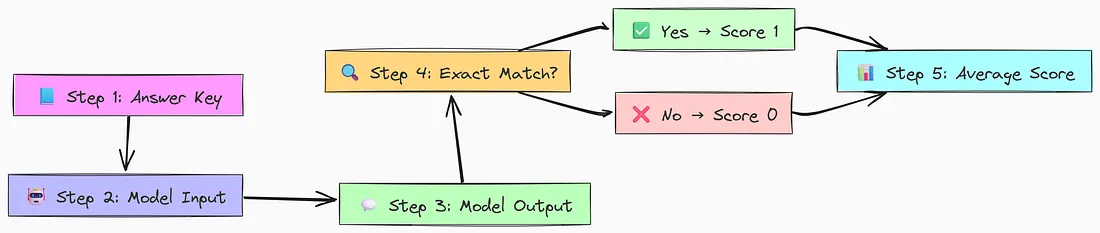

- 우리는 정답 (정답 키라고도 함)을 가지고 있는데, 이는 모델에서 기대하는 정답입니다.
- 다음으로, 모델에 입력을 제공하고 , 모델은 해당 입력을 기반으로 출력을 생성합니다.
- 그런 다음 모델의 출력이 정답 키워드와 단어 하나하나, 문자 하나하나까지 정확히 일치하는지 확인합니다 .
- 일치하면 1점을 부여하고, 일치하지 않으면 0 점을 부여합니다 .
- 마지막으로 모든 예시의 점수를 평균하여 모델의 전반적인 정확한 일치 성능을 얻습니다.

#### 평가 데이터셋 생성하기

평가 데이터셋은 **어떤 LLM 애플리케이션을 테스트하더라도 핵심적인 구성 요소**입니다.
이 데이터셋은 여러 개의 예시(example)로 이루어져 있으며, 각 예시는 다음을 포함합니다:

* **입력(Inputs)**: 모델에 입력될 데이터 (예: 사용자의 프롬프트)
* **출력(참조 레이블, Reference Labels)**: 모델이 생성해야 하는 "정답(ground truth)" 또는 기대하는 결과

여기서는 LangSmith에서 `"Oracle of Exactness"`라는 작은 데이터셋을 직접 생성합니다.
이 데이터셋은 **정확한 출력**을 테스트하기 위해 설계된 두 개의 예시를 포함합니다.
먼저, 중복 생성을 방지하기 위해 해당 데이터셋이 이미 존재하는지 확인합니다.


In [ ]:
import langsmith  # LangSmith 클라이언트 라이브러리 불러오기

client = langsmith.Client()  # LangSmith 클라이언트 인스턴스 생성
dataset_name = "Exact_matching"  # 새 데이터셋 이름 정의

# 해당 이름의 데이터셋이 이미 존재하는지 확인
if not client.has_dataset(dataset_name=dataset_name):
    # 데이터셋이 존재하지 않으면 새로 생성
    ds = client.create_dataset(dataset_name)
    # 새로 만든 데이터셋에 예시 추가
    client.create_examples(
        # 'inputs'는 모델에 전달될 입력을 나타내는 딕셔너리 목록
        inputs=[
            {"prompt": "5는 3보다 작습니까? 응답 형식은 YES 또는 NO로 하시오."},
            {"prompt": "광복절은 몇 월 몇 일입니까? 응답의 형식은 날짜만 다음과 같이 말하시오 : '5/13'"},
        ],
        # 'outputs'는 각 입력에 대한 기대값(정답)을 담은 딕셔너리 목록
        outputs=[{"label": "NO"}, {"label": "8/15"}],
        # 'dataset_id'는 예시들을 위에서 만든 데이터셋에 연결
        dataset_id=ds.id,
    )


#### 시스템과 평가기 정의하기

이제 평가를 실행하기 위해 필요한 구성 요소를 설정하겠습니다.
크게 세 가지 단계로 나눌 수 있습니다.

1. **테스트 대상 시스템(`answer_func`)**

   * 실제로 평가할 함수입니다.
   * 데이터셋 입력 형식과 동일한 딕셔너리를 받아 OpenAI 모델로 응답을 생성하고, 결과를 구조화된 딕셔너리 형태로 반환합니다.

2. **사용자 정의 평가기(`correct`)**

   * 평가할 시스템의 답변과 실제 정답을 비교합니다.



In [ ]:
from langchain_openai import ChatOpenAI    # OpenAI 챗 모델과 상호작용하기 위한 ChatOpenAI 클래스 불러오기
from langsmith import evaluate, traceable, wrappers


model = "gpt-4o-mini"  # 테스트에 사용할 OpenAI 모델 지정

# 평가할 대상 모델/시스템 함수
@traceable
def answer_func(inputs: dict) -> dict:
    response = ChatOpenAI(model=model).invoke(inputs["prompt"])
    # 모델 출력을 표준 딕셔너리 형식으로 반환
    return {"answer": response.content}

def correct(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    return outputs["answer"] == reference_outputs["label"]


results = client.evaluate(
    answer_func,
    data=dataset_name,
    evaluators=[correct],
    experiment_prefix="gpt-4o-mini, baseline",  # optional, experiment name prefix
    description="Testing the baseline system.",  # optional, experiment description
)

### 5-2. AI-Assisted Golden Dataset 구축

지금까지 우리는 '내가 의도한 대로 검색이 잘 되는지' 몇 가지 사례로만 확인했습니다. 하지만 실제 서비스를 운영하려면 수백, 수천 개의 질문에 대해 성능을 보장해야 합니다. 사람이 일일이 테스트 케이스(Q&A)를 만드는 건 너무 힘든 일이죠.
그래서 우리는 **"AI가 AI를 평가하는"** 전략을 사용합니다.
GPT-4o(Vision)에게 보고서 이미지를 식별하게 하고, **"이 내용을 바탕으로 시험 문제를 출제해줘!"** 라고 시키는 것이죠.
우리는 다음 3가지 유형의 난이도별 질문 세트(**Golden Dataset**)를 자동으로 생성할 것입니다.
1.  **Simple (단순 조회)**: 텍스트에 명시된 수치나 사실을 묻는 쉬운 질문 (예: "3월 수출액은?")
2.  **Reasoning (추론)**: 흩어진 정보를 조합하거나 인과관계를 묻는 질문 (예: "수출이 증가한 주요 원인 2가지는?")
3.  **Visual (시각 정보)**: 도표나 그래프를 해석해야만 답할 수 있는 질문 (예: "그래프상에서 가장 가파르게 상승한 구간은?")
특히 중요한 점은, 답변의 정답뿐만 아니라 **"어디를 보고 답했는지(Ground Truth Context)"**도 함께 추출한다는 점입니다. 이는 나중에 RAGAS로 데이터 검색 정확도(`Context Precision`)를 평가할 때 핵심적인 기준이 됩니다.

In [ ]:
import os
import glob
import random
import io
import base64
import json
from pdf2image import convert_from_path
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langsmith import Client

# 1. 환경 설정
DATA_DIR = "/content/data/bok_major_industry_reports"
DATASET_NAME = "LLMOps_Golden_Dataset"

# 2. 이미지 인코딩 헬퍼
def encode_image(image):
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

# 3. 데이터셋 생성 함수 (3페이지 Context 반영)
def generate_golden_dataset(dataset_name, num_samples=3):
    print(f"🚀 Golden Dataset 생성 시작 (3페이지 Context): {dataset_name}...")

    pdf_files = glob.glob(os.path.join(DATA_DIR, "*.pdf"))
    if not pdf_files:
        print(f"❌ PDF 파일을 찾을 수 없습니다: {DATA_DIR}")
        return

    generated_examples = []
    llm = ChatOpenAI(model="gpt-4o", temperature=0.7)

    for i in range(num_samples):
        try:
            target_pdf = random.choice(pdf_files)
            print(f"  - 처리 중 [{i+1}/{num_samples}]: {os.path.basename(target_pdf)}")

            images = convert_from_path(target_pdf)
            if not images: continue

            # 연속된 3페이지 선택 (범위 초과 방지)
            max_start = max(0, len(images) - 3)
            start_idx = random.randint(0, max_start)
            selected_images = images[start_idx : start_idx + 3]

            # 이미지 컨텐츠 준비
            image_contents = []
            for img in selected_images:
                img_b64 = encode_image(img)
                image_contents.append({
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}
                })

            # 프롬프트: 3페이지를 보고 종합적인 문제를 내도록 지시
            prompt = """
            당신은 RAG 시스템 평가를 위한 'Golden Dataset' 생성 전문가입니다.
            제공된 **3장의 연속된 보고서 페이지(이미지)**를 종합적으로 분석하여, 다음 3가지 유형의 질문-답변(QA) 쌍을 1개씩 생성하세요.

            [필수 요구사항]
            1. **상세한 근거(Context)**: 답변의 근거가 된 내용은 **전체 문장(Full Sentence)** 수준으로 길게 발췌하세요.
               - 표나 그래프를 참조했다면, **"표 3-1의 OO 항목"** 처럼 위치를 명시하고 해당 데이터 값을 구체적으로 설명하세요.
               - 단순히 값을 적는 게 아니라, **"어디에 있는 무슨 내용인지"** 알 수 있어야 합니다.
            2. **단위 명시**: 수치형 답변에는 반드시 단위(%, 조 원 등)를 포함하세요.

            [질문 유형]
            1. **Simple**: 텍스트만 잘 읽어도 맞출 수 있도록, **오직 줄글(Text Paragraph)**에 있는 내용에서만 출제하세요.
            2. **Reasoning**: 3장의 내용을 종합하거나 인과관계를 묻는 추론형 질문. (예: "A현상의 원인으로 언급된 2가지는?")
            3. **Visual**: 도표, 그래프, 차트의 시각적 정보를 해석해야 답할 수 있는 질문.

            반드시 아래 JSON 형식으로만 출력하세요. (마크다운 태그 제외)
            {
                "samples": [
                    {"type": "Simple", "question": "...", "answer": "...", "context": "..."},
                    {"type": "Reasoning", "question": "...", "answer": "...", "context": "..."},
                    {"type": "Visual", "question": "...", "answer": "...", "context": "..."}
                ]
            }
            """

            msg = HumanMessage(content=[{"type": "text", "text": prompt}] + image_contents)

            res = llm.invoke([msg])

            # JSON 파싱
            content = res.content.replace("```json", "").replace("```", "").strip()
            data = json.loads(content)

            for sample in data.get("samples", []):
                sample["source"] = os.path.basename(target_pdf)
                sample["page_range"] = f"{start_idx+1}~{start_idx+3}"
                generated_examples.append(sample)
                print(f"    ✅ [{sample['type']}] Q: {sample['question']}")

        except Exception as e:
            print(f"    ⚠️ 오류 발생: {e}")
            continue

    # LangSmith 업로드
    if not generated_examples: return

    client = Client()
    if client.has_dataset(dataset_name=dataset_name):
        print(f"  - 기존 데이터셋 '{dataset_name}'에 추가합니다...")
        ds = client.read_dataset(dataset_name=dataset_name)
    else:
        print(f"  - 새로운 데이터셋 '{dataset_name}'을 생성합니다...")
        ds = client.create_dataset(dataset_name=dataset_name)

    inputs = [{"question": ex["question"]} for ex in generated_examples]
    outputs = [{
        "answer": ex["answer"],
        "ground_truth_context": ex.get("context", ""),
        "type": ex["type"],
        "source": ex["source"]
    } for ex in generated_examples]

    client.create_examples(
        inputs=inputs,
        outputs=outputs,
        dataset_id=ds.id
    )
    print(f"\n🎉 데이터셋 구축 완료! 총 {len(generated_examples)}개의 새로운 케이스가 저장되었습니다.")

# --- 실행 ---
generate_golden_dataset(DATASET_NAME, num_samples=5)



### 5-3. 정량화된 평가 시스템 실행 (Basic vs Self-Query)

앞서 구축한 Golden Dataset을 사용하여 두 RAG 시스템의 성능을 정량적으로 비교해봅니다.
우리는 평가의 일관성과 자동화를 위해 data/evaluate_rag.py 모듈을 미리 작성해두었습니다.

이 스크립트는 내부적으로 **RAGAS** 라이브러리를 사용하여 다음 3가지 핵심 지표를 측정합니다.
1.  **Context Precision**: (검색) 정답 문서를 정확히 찾아왔는가?
2.  **Faithfulness**: (생성) 검색된 문서에 없는 내용을 지어내지 않았는가?
3.  **Answer Relevancy**: (생성) 질문의 의도에 맞는 답변을 했는가?

특히 **Basic RAG**는 메타데이터 필터링이 없이 문서를 가져오는 경우가 많으므로, **Self-Query RAG** 대비 점수가 어떻게 나오는지 비교해보는 것이 관전 포인트입니다.

In [ ]:
from data.evaluate_rag import evaluate_rag_app

DATASET_NAME = "LLMOps_Golden_Dataset"

In [ ]:
# 1. Basic RAG 평가 실행
await evaluate_rag_app("basic_rag", DATASET_NAME)

In [ ]:
# 2. Self-Query RAG 평가 실행
await evaluate_rag_app("self_retriever_rag", DATASET_NAME)